In [1]:
from pprint import pprint
import pandas as pd
import numpy as np
import scipy as sp
import pickle
import cloudpickle
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from IPython.display import display
import shap
from comparers import ModelComparer, plot_decision_boundary
from util import RuleClassifier, get_complexity, find_counterfactuals, counterfactuals_to_constraint_matrix,\
                 evaluate, group_metrics
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order,\
                       plot_feature_importance_bar, plot_class_importances, print_rules
from clustering import make_clustering, eval_clusterings, plot_2d_with_boundaries, compare_indiv_dep_plots
import warnings
shap.initjs()

In [2]:
with open('task.pickle', 'rb') as f:
    clf_a, clf_b, X, y, feature_names, feature_precisions = pickle.load(f)

In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

In [4]:
def load(focus_class):
    with open(f'clustering.diffclf.{focus_class}.pickle', 'rb') as f:
        state = pickle.load(f)
    node = make_clustering(comparer, diffclf_shap_values, focus_class,
                           feature_precisions=feature_precisions, state=state)
    return node

In [5]:
# Do not sample from background data set but use all available instances
masker = shap.maskers.Independent(data=X, max_samples=X.shape[0])

# Generating Explanations

In [6]:
%%time
indiv_shap_values = generate_shap_explanations(comparer, X, masker=masker, explanation_type='indiv', space_type='labels')
with open('indiv.shap', 'wb') as f:
    pickle.dump(indiv_shap_values, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 3.91 s, sys: 65.8 ms, total: 3.98 s
Wall time: 4.17 s


In [7]:
%%time
diffclf_shap_values = generate_shap_explanations(comparer, X, masker=masker, explanation_type='mclass_diff', space_type='labels')
with open('diffclf.shap', 'wb') as f:
    pickle.dump(diffclf_shap_values, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 112 ms, sys: 5.64 ms, total: 118 ms
Wall time: 152 ms


In [8]:
%%time
for class_name in comparer.class_names:
    print(class_name)
    node = make_clustering(comparer, diffclf_shap_values, class_name,
                           feature_precisions=feature_precisions)
    with open(f'clustering.diffclf.{node.focus_class}.pickle', 'wb') as f:
        pickle.dump(node.state, f)

(0, 0)
(0, 1)
(1, 0)
(1, 1)
CPU times: user 15.8 s, sys: 90.8 ms, total: 15.8 s
Wall time: 16.1 s


# Traditional SHAP Explanations

In [6]:
with open('indiv.shap', 'rb') as f:
    indiv_shap_values = pickle.load(f)

In [7]:
# For binary classification problems only the positive class is interesting
indiv_shap_values = indiv_shap_values[:, :, ['A.1', 'B.1']]

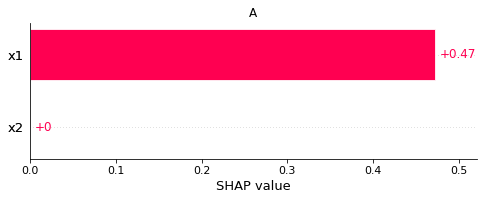

In [8]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, 'A.1'])
plot_feature_importance_bar(feature_importance, 'A', feature_order)

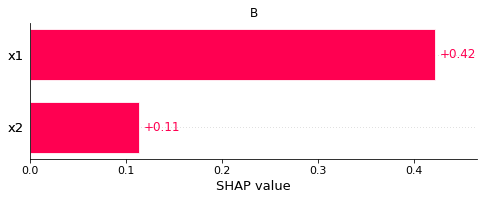

In [9]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, 'B.1'])
plot_feature_importance_bar(feature_importance, 'B', feature_order)

In [10]:
%%time
node = make_clustering(comparer, indiv_shap_values, feature_precisions=feature_precisions)

CPU times: user 114 ms, sys: 7.51 ms, total: 121 ms
Wall time: 158 ms


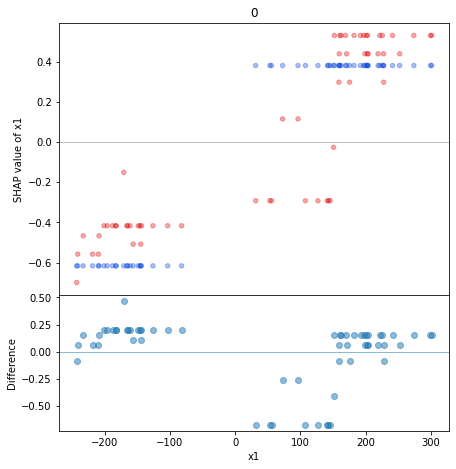

In [11]:
compare_indiv_dep_plots(node, 'x1')

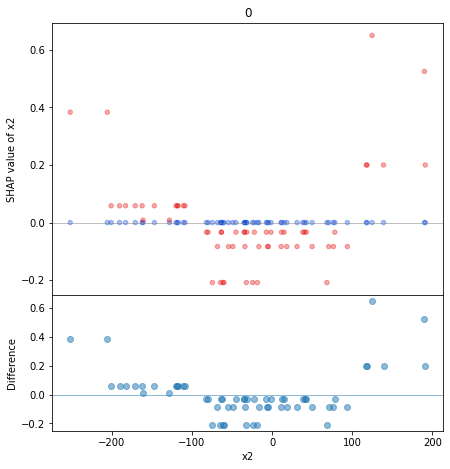

In [12]:
compare_indiv_dep_plots(node, 'x2')

# Difference Classifier SHAP Explanations

In [5]:
with open('diffclf.shap', 'rb') as f:
    diffclf_shap_values = pickle.load(f)

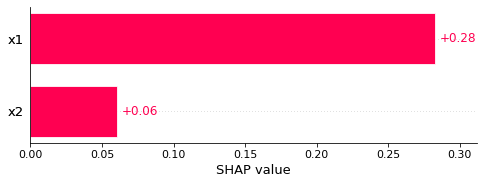

In [6]:
feature_order, feature_importances = calc_feature_order(diffclf_shap_values)
plot_feature_importance_bar(feature_importances)

Next, I will have a look at each difference class separately, and interpret it in contrast to the equality classes $(0,0)$ and $(1,1)$. This is an incomplete comparison, because in order for it to be complete, I would need to add the other difference class to the comparison classes. I'm leaving this one out as it is my goal to keep the explanations selected.

## (0,0)

In [68]:
node = load('(0, 0)')
node.distance, node.class_counts

(2.5805555555555557,
 (1, 1)    29
 (0, 0)    22
 (1, 0)     8
 (0, 1)     1
 dtype: int64)

In [69]:
node.focus_class

'(0, 0)'

In [70]:
node.pred_classes[node.highlight]

array(['(1, 1)', '(1, 1)', '(1, 1)', '(1, 1)', '(1, 1)', '(1, 1)',
       '(1, 1)', '(1, 1)', '(1, 1)', '(1, 1)', '(1, 1)', '(1, 1)',
       '(1, 1)', '(1, 1)', '(1, 1)', '(1, 1)', '(1, 1)', '(1, 1)',
       '(1, 1)', '(1, 1)', '(1, 1)', '(1, 1)', '(1, 1)', '(1, 1)',
       '(1, 1)', '(1, 1)', '(1, 1)', '(1, 1)', '(1, 1)'], dtype='<U6')

In [65]:
node = node.get_last_child_before_focus_class_split()
node, node.distance, node.class_counts

(LR,
 0.18055555555555552,
 (0, 0)    22
 dtype: int64)

In [67]:
node.pred_classes[node.highlight]

array([], dtype='<U6')

Focus class instances: Counterfactuals: [Lower CF: x1 == -8.6 --> {'(0, 0)': 15, '(0, 1)': 14}]


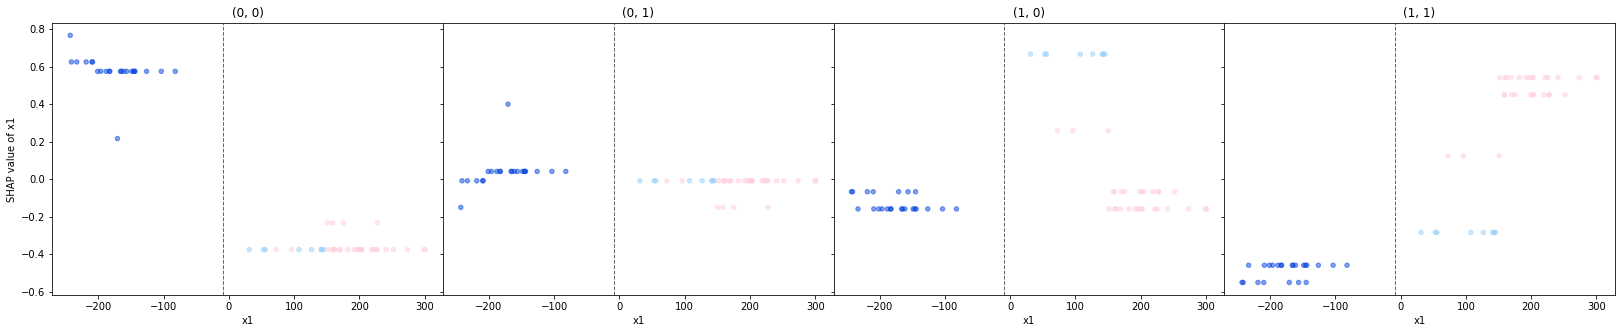

Focus class instances: Counterfactuals: []


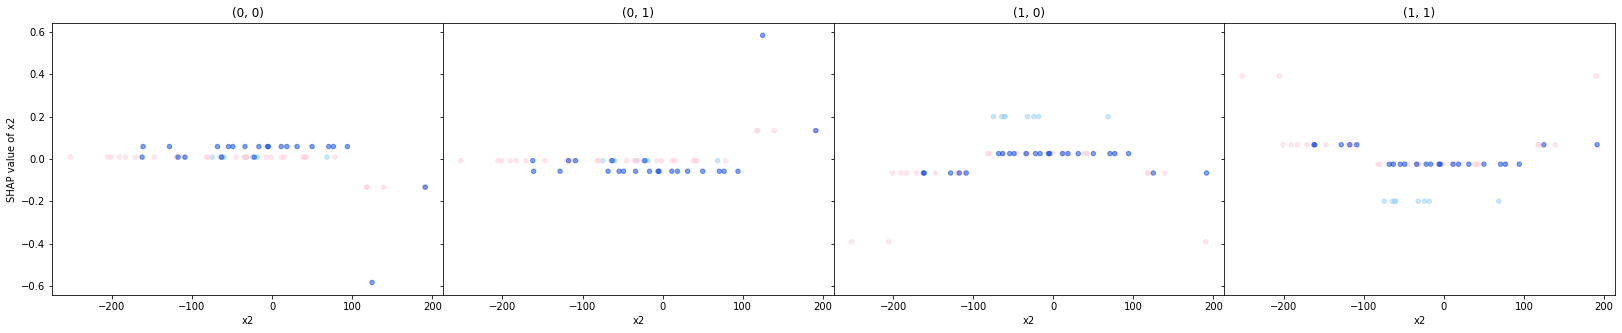

In [66]:
node.root.plot_feature_dependence(*feature_names, focus=node.parent, print_stats=True)

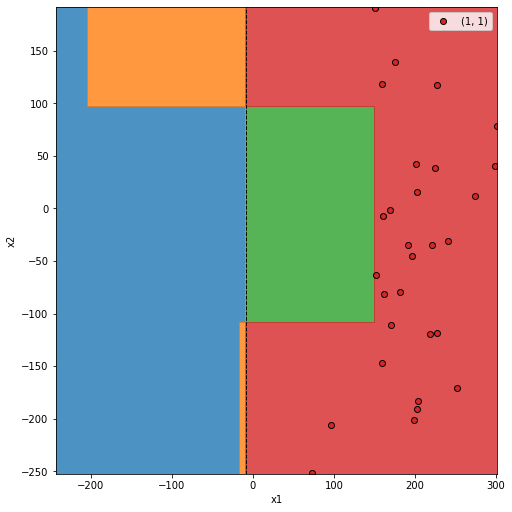

In [17]:
plot_2d_with_boundaries(node)

## (0,1)

In [32]:
node = load('(0, 1)')
node.distance, node.class_counts

(2.5805555555555557,
 (1, 1)    29
 (0, 0)    22
 (1, 0)     8
 (0, 1)     1
 dtype: int64)

The dendrogram shows the clustering hierarchy. In this case it is simple.

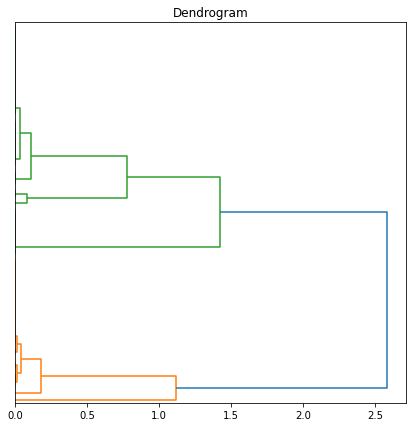

In [33]:
node.plot_dendrogram()

Next I will create dependence plots for each feature. For each feature, there is one plot for the difference class (middle) and one plot each for the equality classes (left and right). Since the dependence plot shows for each instance, what it's SHAP value is in relation to its feature value, we an interpret what the relation between the input and output might be. The instances are colored by their actual label: those classified as the current difference class in red, others in blue.

Additionally, I print the following information to get a better understanding:
- Feature value range of instances classified as the current difference class
- Group counterfactuals

The group counterfactuals are also visualized in the dependence plot via a vertical dashed line.

For $x_1$, there is a lower counterfactual of -203.8, where all instances classified as the current difference class flip their prediction to $(0,0)$, and an upper counterfactual of -8.5, where they flip to $(1,1)$. Looking at the dependence plots, I can interpret the following effects of this feature:
- For values below the lower counterfactual, the SHAP values of $(0,0)$ are in a global high, while both the SHAP values of $(0,1)$ and $(1,1)$ are in a global low.
- For values between the lower counterfactual and the upper counterfactual, the SHAP values of $(1,1)$ are in a global low, while those of $(0,1)$ are in a global high and those of $(0,0)$ in the mid-range. Further, this range includes both instances classified as the current difference class (colored red) and other instances (colored blue). There is a vertical spread between these groups, that results from interactions with other features. Two instances with the same $x_1$ value might have a different SHAP value for this feature, when they have different values in other features. The instances in red have higher SHAP values for $(0,1)$ but lower for $(1,1)$ compared to those in blue. This leads to the conclusion, that there have to be certain values of $x_2$ that lead to them having bigger SHAP values in $(0,1)$ and at the same time lower SHAP values in $(0,0)$.
- For values above the upper counterfactual, both $(0,0)$ and $(0,1)$ are at their lowest, but $(1,1)$ is highest, with different levels present.

If the feature values of the instances classified $(0,1)$ would be decreased, I would expect the $(0,1)$ SHAP values to decrease abruptly and those of $(0,0)$ to increase abruptly at a certain point, possibly flipping the prediction to $(0,0)$. The lower CF supports this theory, because all of them actually flip to $(0,0)$ at -203.8. The same is true vice versa for $(1,1)$ if x1 would be increased to the upper CF at -8.5.

Focus class instances: x1 == -170.7851609814319
Counterfactuals: [Lower CF: x1 == -203.8 --> {'(0, 0)': 1},
 Upper CF: x1 == -8.5 --> {'(1, 1)': 1}]


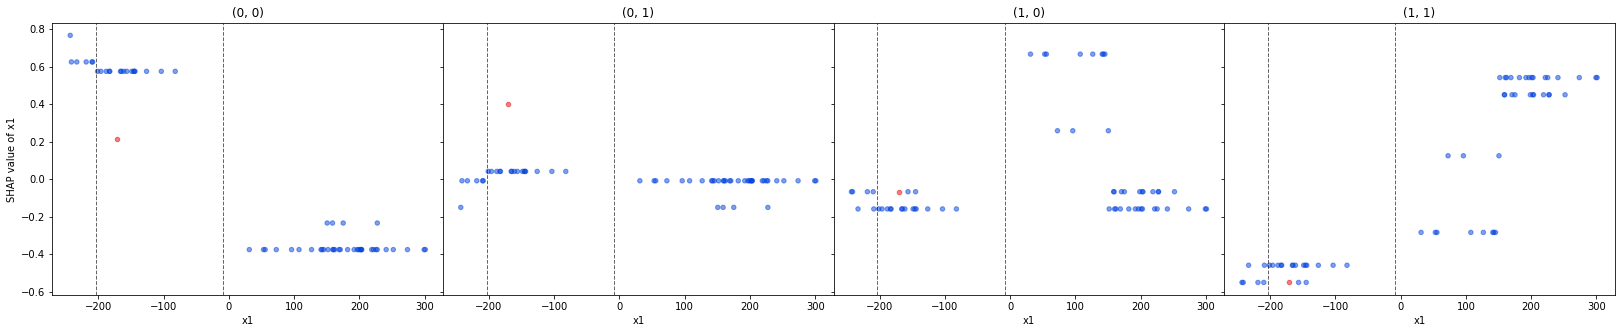

Focus class instances: x2 == 124.8450298019977
Counterfactuals: [Lower CF: x2 == 97.5 --> {'(0, 0)': 1}]


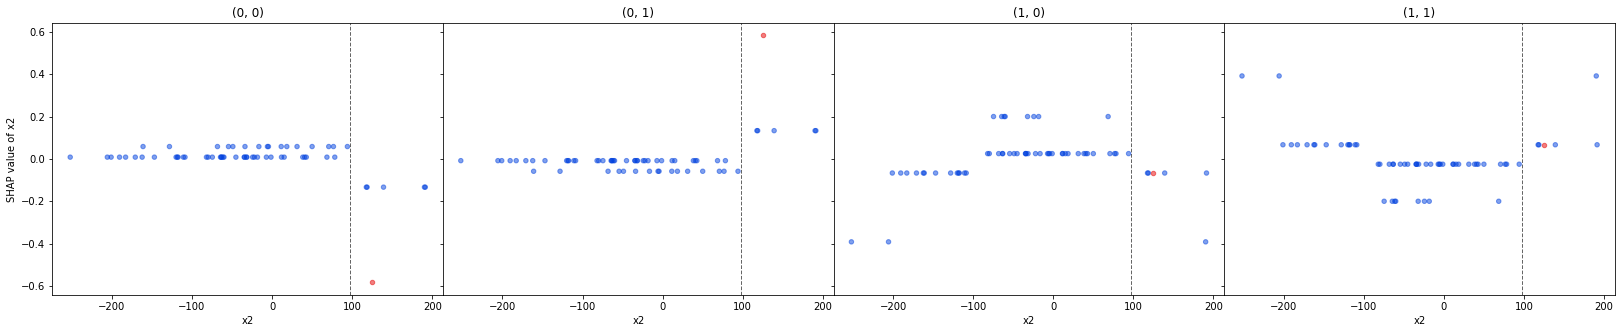

In [34]:
node.plot_feature_dependence(*feature_names, print_stats=True)

For $x_2$ there exists only a lower counterfactual at 97.5. Using the dependence plots I can interpret:
- Below approx. -100, $(1,1)$ is in a global high, while both $(0,0)$ and $(0,1)$ are in a global low.
- Further above up to the lower counterfactual, $(0,0)$ is in a global high and both $(0,1)$ and $(1,1)$ are in a global low.
- Above the lower counterfactual, $(0,1)$ and $(1,1)$ are in a global high. In $(0,1)$, the red instances have higher SHAP values than the blue, but in $(1,1)$ it is not so clear, because red instances are mixed with blue instances.

Based on the knowledge that obtained so far I can reason, that instances with the following rule are likely to be classified as $(0,1)$. The rule, evaluated on the data set achieves perfect performance.

In [35]:
node.rule_from_counterfactuals()[0]

'-203.8 < x1 <= -8.6 and x2 > 97.5'

Having analyzed the global explanations, I will now check the next levels of the cluster hierarchy.

### Node LL

In [36]:
node = node.root.get_left().get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(LL,
 (0, 1)    1
 dtype: int64,
 0)

Focus class instances: x1 == -170.7851609814319
Counterfactuals: [Lower CF: x1 == -203.8 --> {'(0, 0)': 1},
 Upper CF: x1 == -8.5 --> {'(1, 1)': 1}]


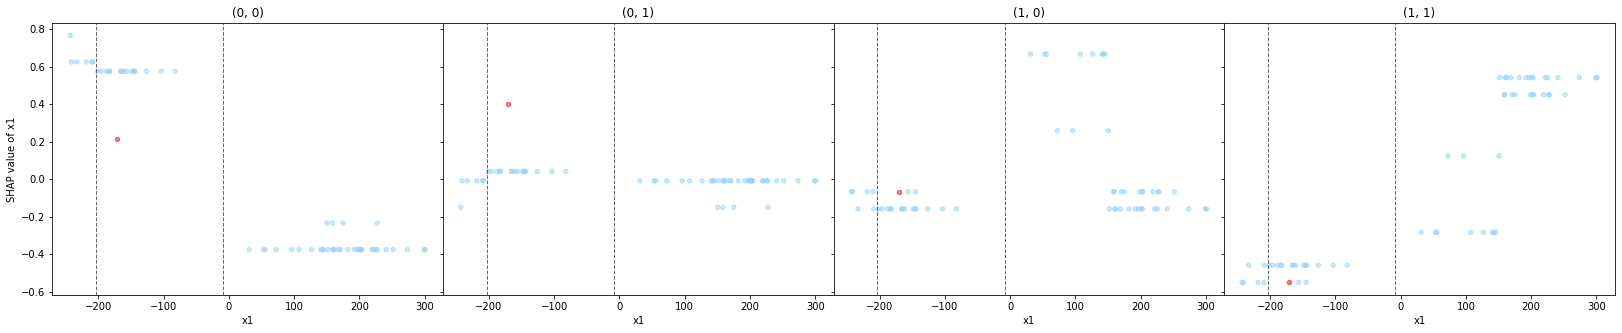

Focus class instances: x2 == 124.8450298019977
Counterfactuals: [Lower CF: x2 == 97.5 --> {'(0, 0)': 1}]


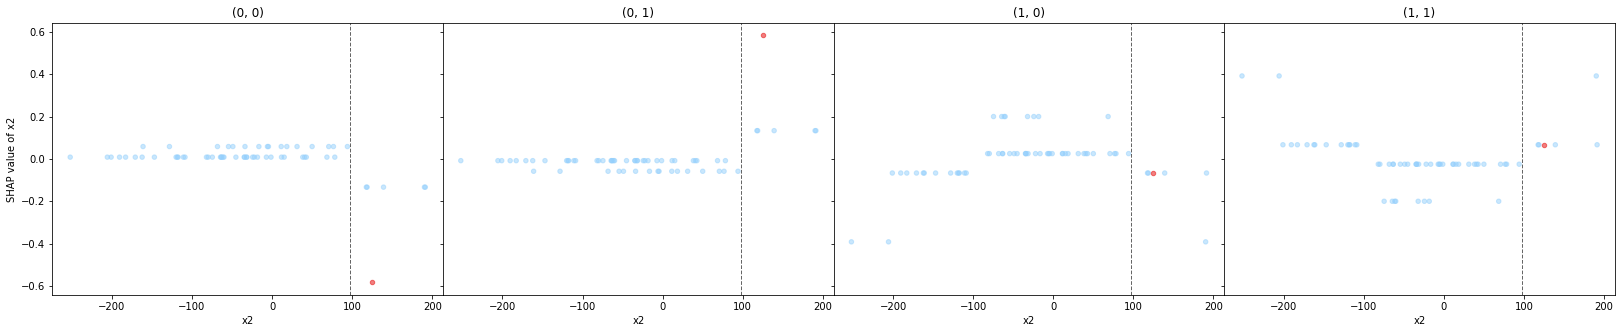

In [38]:
node.root.plot_feature_dependence(*feature_names, focus=node, print_stats=True)

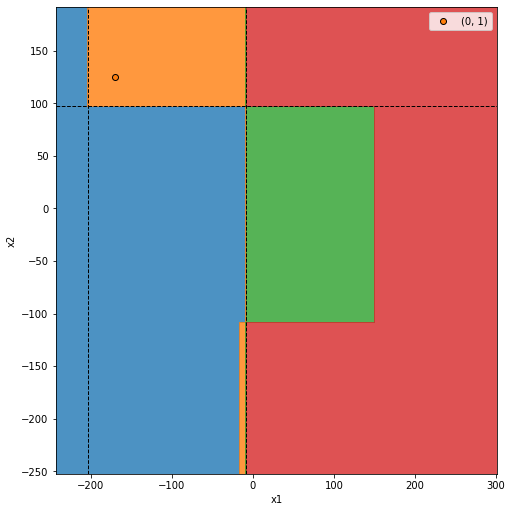

In [39]:
plot_2d_with_boundaries(node)

## (1,0)

In [41]:
node = load('(1, 0)')
node.distance, node.class_counts

(2.5805555555555557,
 (1, 1)    29
 (0, 0)    22
 (1, 0)     8
 (0, 1)     1
 dtype: int64)

Focus class instances: 31.276098500397275 <= x1 <= 145.36526911137602
Counterfactuals: [Lower CF: x1 == -8.6 --> {'(0, 0)': 8},
 Upper CF: x1 == 150.8 --> {'(1, 1)': 8}]


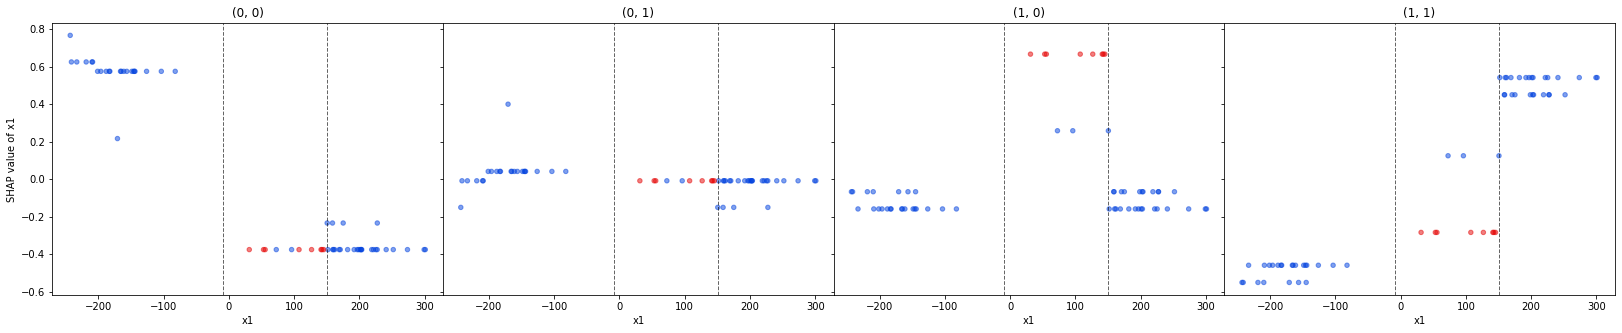

Focus class instances: -74.55964142526199 <= x2 <= 68.47599689489094
Counterfactuals: [Lower CF: x2 == -108.2 --> {'(1, 1)': 8},
 Upper CF: x2 == 97.6 --> {'(1, 1)': 8}]


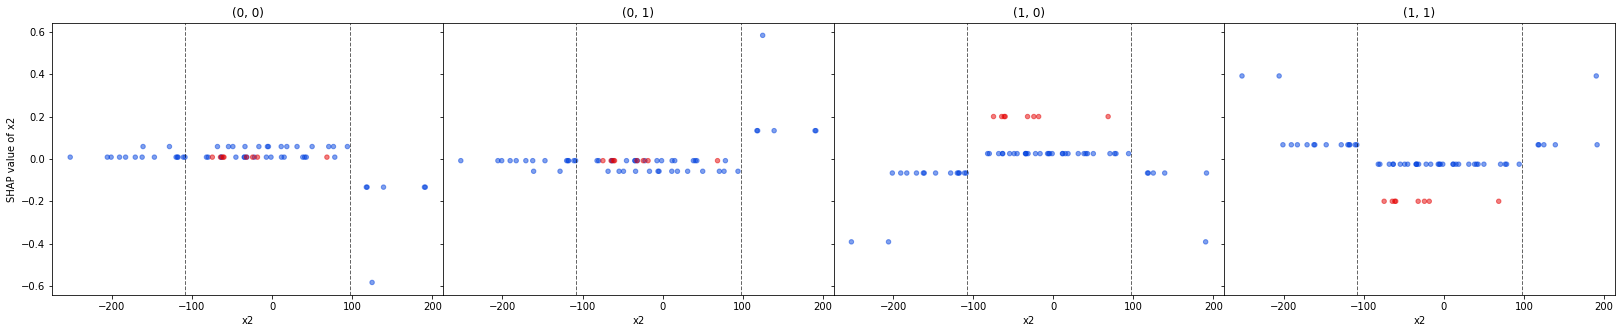

In [42]:
node.plot_feature_dependence(*feature_names, print_stats=True)

This time, I will descend the cluster hierarchy until the last node, the contains all instances classified $(1,0)$. It helps to enrich the partial dependence plots with clustering context.

### Node 1 (RL)

I arrive at the left child of the right child of the root node. All other instances are in different nodes. It is a leaf node, because the distance is 0.

In [43]:
node = node.get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(RL,
 (1, 0)    8
 dtype: int64,
 0.0)

The parent node (R) contains additionally the instances classified $(1,1)$. I will use this as the reference node, to be highlighted in the global dependence plots.

In [44]:
node = node.parent
node.class_counts

(1, 1)    29
(1, 0)     8
dtype: int64

Focus class instances: 31.276098500397275 <= x1 <= 145.36526911137602
Counterfactuals: [Lower CF: x1 == -8.6 --> {'(0, 0)': 8},
 Upper CF: x1 == 150.8 --> {'(1, 1)': 8}]


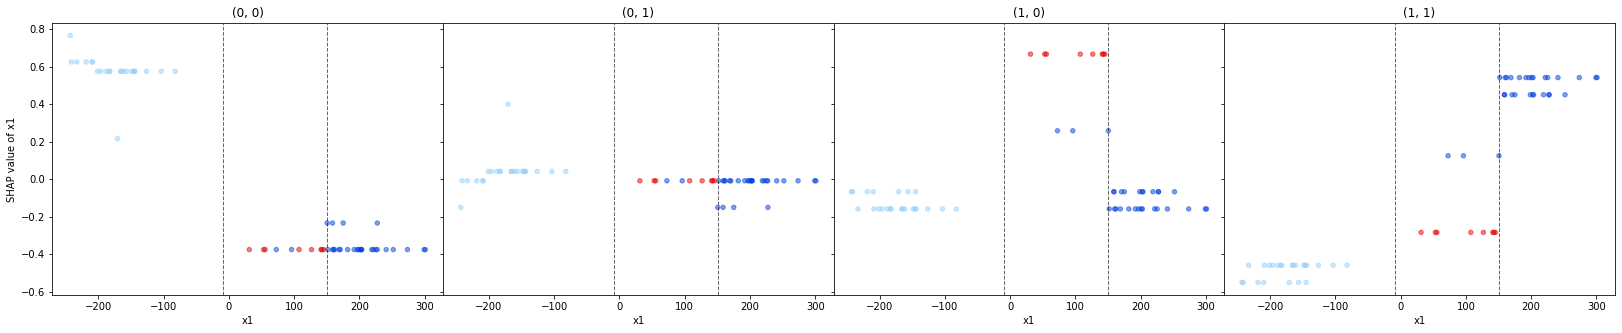

Focus class instances: -74.55964142526199 <= x2 <= 68.47599689489094
Counterfactuals: [Lower CF: x2 == -108.2 --> {'(1, 1)': 8},
 Upper CF: x2 == 97.6 --> {'(1, 1)': 8}]


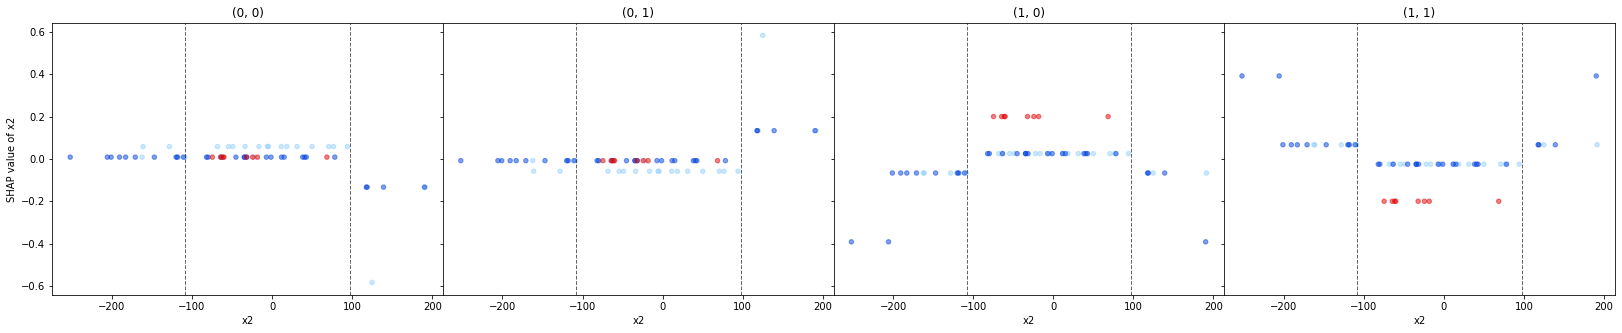

In [45]:
node.root.plot_feature_dependence(*feature_names, focus=node, print_stats=True)

There is a lower and an upper CF for x1:
- Below the lower CF, $(0,0)$ is in a global high, while $(1,0)$ and $(1,1)$ remain in a global low. Only non-highlighted instance are there, that is, those classified $(0,0)$.
- Between the lower and upper CF are instances classified $(1,0)$ (red). This class has a global high here. $(0,0)$ is in a global low, but $(1,1)$ is in mid-range. Clearly, interaction effects determine, whether the SHAP value of x1 increases for $(1,0)$ and at the same time decreases for $(1,1)$, or increases slightly for $(1,0)$ and also increases slightly for $(1,1)$.
- Above the upper CF $(1,1)$ is in a global high, while the others are in a global low.

There is a lower and an upper CF for x2:
- Below the lower CF, $(1,1)$ and $(0,0)$ are in a global high while $(1,0)$ is in a global low. 
- Between the lower and the upper CF, $(1,0)$ and $(0,0)$ are in a global high, while $(1,1)$ is in a global low. Both instances classsified $(1,0)$ and not like this are within this range. Interaction effects with other features determine whether the SHAP value of $(1,0)$ is higher or lesser.
- Above the upper CF, $(1,1)$ is in a global high while the others are in a global low.

In [46]:
node.rule_from_counterfactuals()[0]

'-8.6 < x1 <= 150.7 and -108.2 < x2 <= 97.5'

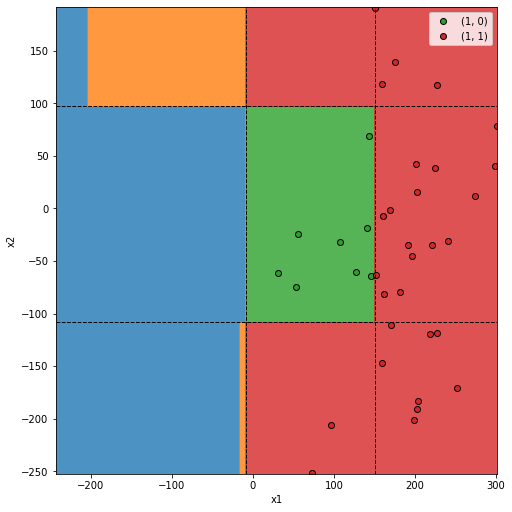

In [47]:
plot_2d_with_boundaries(node)

## (1,1)

In [7]:
node = load('(1, 1)')
node.distance, node.class_counts

(2.5805555555555557,
 (1, 1)    29
 (0, 0)    22
 (1, 0)     8
 (0, 1)     1
 dtype: int64)

In [11]:
node = node.get_last_child_before_focus_class_split()
print(node)

RR


['x1 <= 148.0 and x2 <= -183.9', 'x1 > 148.0']

Focus class instances: 72.63708530898366 <= x1
Counterfactuals: [Lower CF: x1 == -8.6 --> {'(0, 0)': 15, '(0, 1)': 14}]


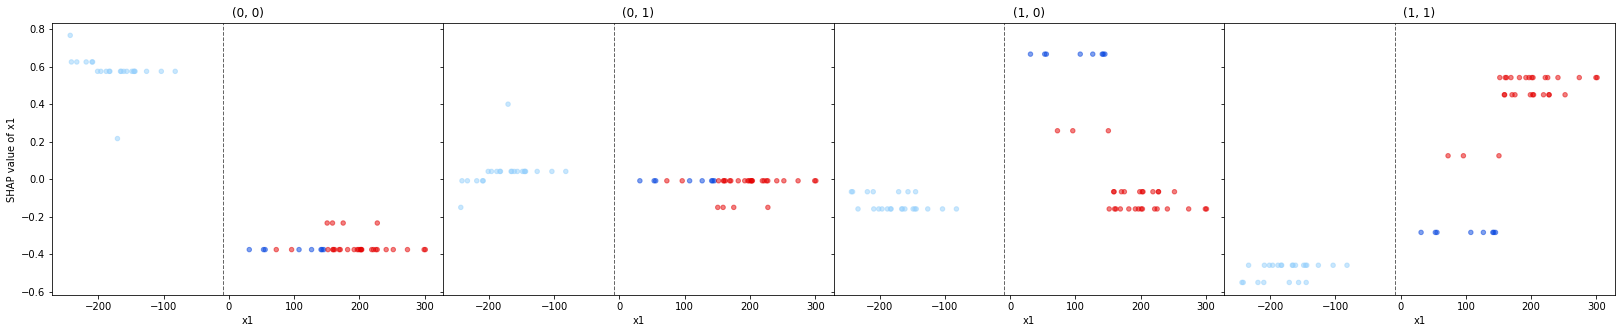

Focus class instances: x2 <= 190.20172233005366
Counterfactuals: []


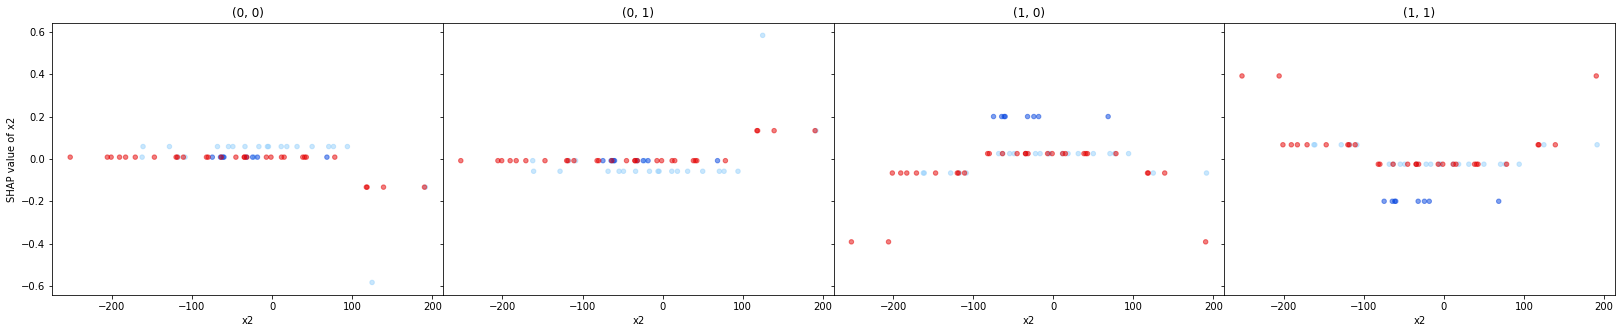

In [12]:
node.root.plot_feature_dependence(*feature_names, focus=node.parent, print_stats=True)

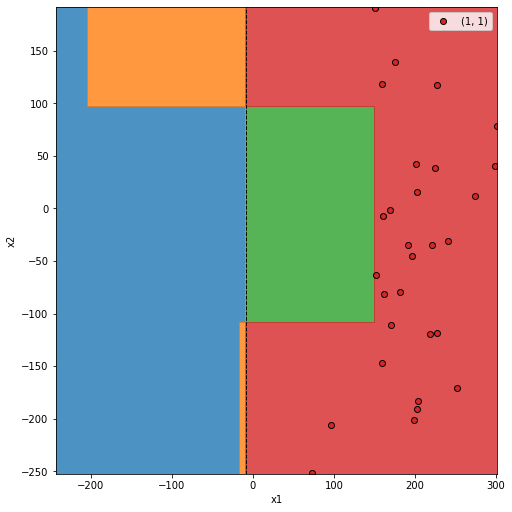

In [17]:
plot_2d_with_boundaries(node)

# Evaluation

In [6]:
with open('diffclf.shap', 'rb') as f:
    diffclf_shap_values = pickle.load(f)

In [7]:
with open('test.pickle', 'rb') as f:
    X_test, y_test = pickle.load(f)

In [21]:
%%time
shap_values_test = generate_shap_explanations(comparer, X_test, masker=masker, explanation_type='mclass_diff', space_type='labels')
with open('test.shap', 'wb') as f:
    pickle.dump(shap_values_test, f)

Exact explainer: 10001it [00:18, 317.02it/s]                          


CPU times: user 17.7 s, sys: 428 ms, total: 18.1 s
Wall time: 19.1 s


In [8]:
with open('test.shap', 'rb') as f:
    shap_values_test = pickle.load(f)

In [9]:
explanations_per_class = {}
for class_name in comparer.class_names:
    explanations_per_class[class_name] = load(class_name)

In [10]:
metrics = eval_clusterings(explanations_per_class, X_test, y_test, shap_values_test, comparer.class_names)
metrics

,Precision,Recall,F1 Score,Support,Label,Nodes,Distance,Constraints
0,0.859601,0.999259,0.924184,4050.0,"(0, 0)",1,2.580556,1
1,0.981805,0.999259,0.990455,4050.0,"(0, 0)",2,0.043611,2
2,1.000000,0.999012,0.999506,4050.0,"(0, 0)",3,0.010000,3
3,1.000000,0.998765,0.999382,4050.0,"(0, 0)",5,0.000000,7
4,0.998397,0.942511,0.969650,661.0,"(0, 1)",1,2.580556,3
5,0.998774,0.999693,0.999233,3259.0,"(1, 0)",1,2.580556,4
6,0.383598,1.000000,0.554493,2030.0,"(1, 1)",1,2.580556,1
7,0.383598,1.000000,0.554493,2030.0,"(1, 1)",2,0.113889,2
8,0.383598,1.000000,0.554493,2030.0,"(1, 1)",3,0.033611,3
9,0.998524,0.999507,0.999015,2030.0,"(1, 1)",5,0.000000,7


In [11]:
grouped_metrics, constraints = group_metrics(metrics, by='Distance', direction='down')

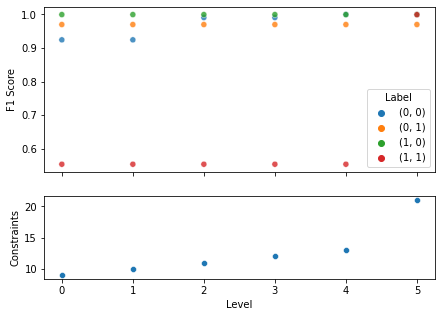

In [12]:
fig, axs = plt.subplots(nrows=2, figsize=(7, 5), sharex='all', gridspec_kw={'height_ratios': [2,1]})
sns.scatterplot(data=grouped_metrics, x='Level', y='F1 Score', hue='Label', alpha=0.8, ax=axs[0])
sns.scatterplot(data=constraints, ax=axs[1])
axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig('running-shap-fidelity.pdf')

In [13]:
grouped_metrics

Label  Precision    Recall  F1 Score  Support  Nodes  Distance  \
Level                                                                      
0     0  (0, 0)   0.859601  0.999259  0.924184   4050.0    1.0  2.580556   
      1  (0, 1)   0.998397  0.942511  0.969650    661.0    1.0  2.580556   
      2  (1, 0)   0.998774  0.999693  0.999233   3259.0    1.0  2.580556   
      3  (1, 1)   0.383598  1.000000  0.554493   2030.0    1.0  2.580556   
1     0  (0, 0)   0.859601  0.999259  0.924184   4050.0    1.0  2.580556   
      1  (0, 1)   0.998397  0.942511  0.969650    661.0    1.0  2.580556   
      2  (1, 0)   0.998774  0.999693  0.999233   3259.0    1.0  2.580556   
      3  (1, 1)   0.383598  1.000000  0.554493   2030.0    2.0  0.113889   
2     0  (0, 0)   0.981805  0.999259  0.990455   4050.0    2.0  0.043611   
      1  (0, 1)   0.998397  0.942511  0.969650    661.0    1.0  2.580556   
      2  (1, 0)   0.998774  0.999693  0.999233   3259.0    1.0  2.580556   
      3  (1, 1)   0.383598  1.000000  0.554493   2030.0    2.0  0.113889   
3     0  (0, 0)   0.981805  0.999259  0.990455   4050.0    2.0  0.043611   
      1  (0, 1)   0.998397  0.942511  0.969650    661.0    1.0  2.580556   
      2  (1, 0)   0.998774  0.999693  0.999233   3259.0    1.0  2.580556   
      3  (1, 1)   0.383598  1.000000  0.554493   2030.0    3.0  0.033611   
4     0  (0, 0)   1.000000  0.999012  0.999506   4050.0    3.0  0.010000   
      1  (0, 1)   0.998397  0.942511  0.969650    661.0    1.0  2.580556   
      2  (1, 0)   0.998774  0.999693  0.999233   3259.0    1.0  2.580556   
      3  (1, 1)   0.383598  1.000000  0.554493   2030.0    3.0  0.033611   
5     0  (0, 0)   1.000000  0.998765  0.999382   4050.0    5.0  0.000000   
      1  (0, 1)   0.998397  0.942511  0.969650    661.0    1.0  2.580556   
      2  (1, 0)   0.998774  0.999693  0.999233   3259.0    1.0  2.580556   
      3  (1, 1)   0.998524  0.999507  0.999015   2030.0    5.0  0.000000   

         Constraints  
Level                 
0     0          1.0  
      1          3.0  
      2          4.0  
      3          1.0  
1     0          1.0  
      1          3.0  
      2          4.0  
      3          2.0  
2     0          2.0  
      1          3.0  
      2          4.0  
      3          2.0  
3     0          2.0  
      1          3.0  
      2          4.0  
      3          3.0  
4     0          3.0  
      1          3.0  
      2          4.0  
      3          3.0  
5     0          7.0  
      1          3.0  
      2          4.0  
      3          7.0

In [14]:
constraints

Level
0     9.0
1    10.0
2    11.0
3    12.0
4    13.0
5    21.0
Name: Constraints, dtype: float64

# Additional Plots

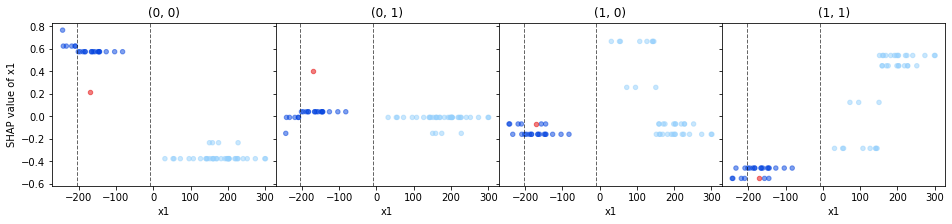

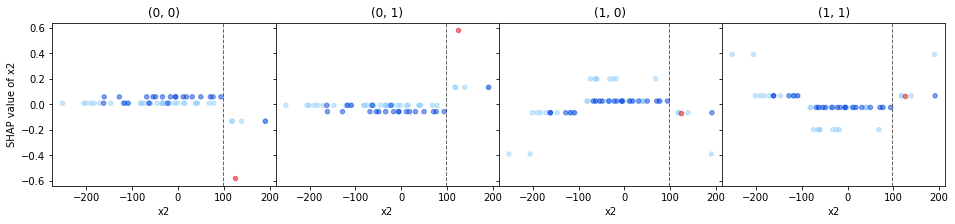

In [23]:
node = load('(0, 1)')
node = node.get_last_child_before_focus_class_split().parent
node.root.plot_feature_dependence('x1', focus=node, figsize=(4, 3), show=False)
plt.savefig('runex-global-depplots-01-x1.pdf')
node.root.plot_feature_dependence('x2', focus=node, figsize=(4, 3), show=False)
plt.savefig('runex-global-depplots-01-x2.pdf')

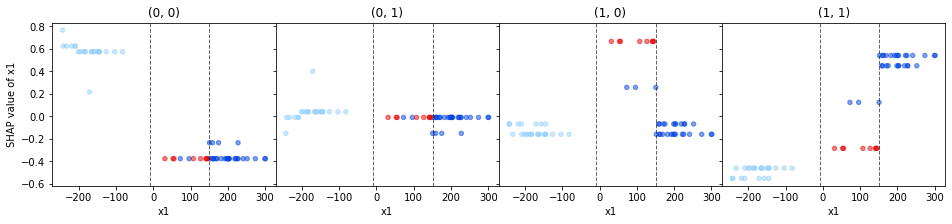

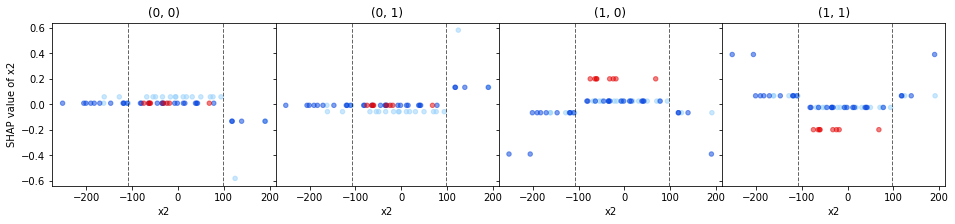

In [24]:
node = load('(1, 0)')
node = node.get_last_child_before_focus_class_split().parent
node.root.plot_feature_dependence('x1', focus=node, figsize=(4, 3), show=False)
plt.savefig('runex-global-depplots-10-x1.pdf')
node.root.plot_feature_dependence('x2', focus=node, figsize=(4, 3), show=False)
plt.savefig('runex-global-depplots-10-x2.pdf')